<h1><center>Práctica 5</center></h1>
<h2><center>Segmentación de Imagen (II) </center></h2>

El objetivo de esta práctica es familiarizar al alumno con las técnicas de extracción de características a fin de abordar un problema de segmentación utilizando aprendizaje no supervisado, en concreto el algoritmo k-medias. Para ello se trabajará con la imagen en color ‘cormoran.jpg’, que acompaña al material de esta práctica.  
 

In [1]:
#importamos librerías necesarias
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

import texturefilters as tf

I. Análisis visual de la imagen 
 
Lea en MATLAB la imagen ‘cormoran.jpg’ proporcionada como material adjunto en la práctica y almacénela en la variable I. Examine visualmente la imagen (representada en la Figura 1) y responda a las siguientes preguntas: 
- ¿qué objetos considera claramente discriminativos en la imagen? 
- a simple vista, ¿qué características considera discriminativas? 


<IPython.core.display.Javascript object>


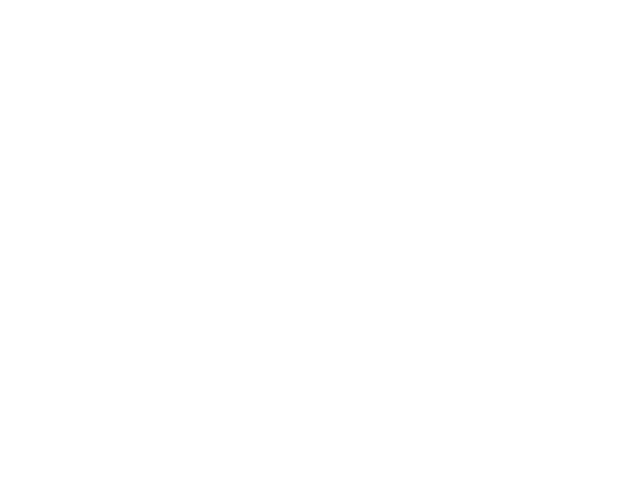

In [2]:
I = cv2.imread('cormoran_rgb.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)


%matplotlib notebook
plt.figure(1)
plt.imshow(I)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

Convierta la imagen a escala de grises (variable I_gris) y analice visualmente su histograma. ¿Cree que podría realizar la segmentación mediante umbralización múltiple? Justifique su respuesta. 

<IPython.core.display.Javascript object>


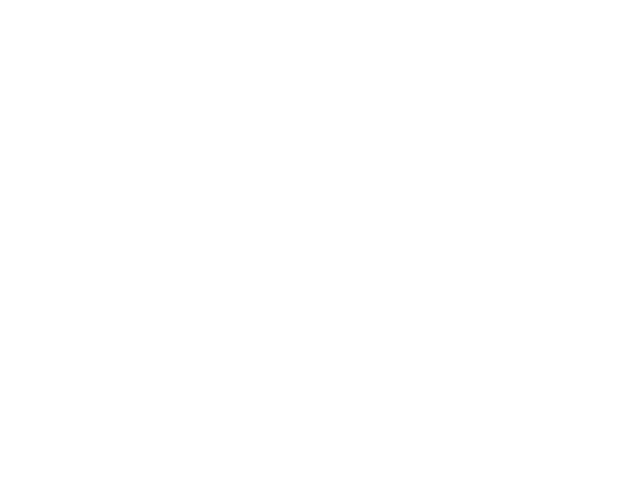

<IPython.core.display.Javascript object>


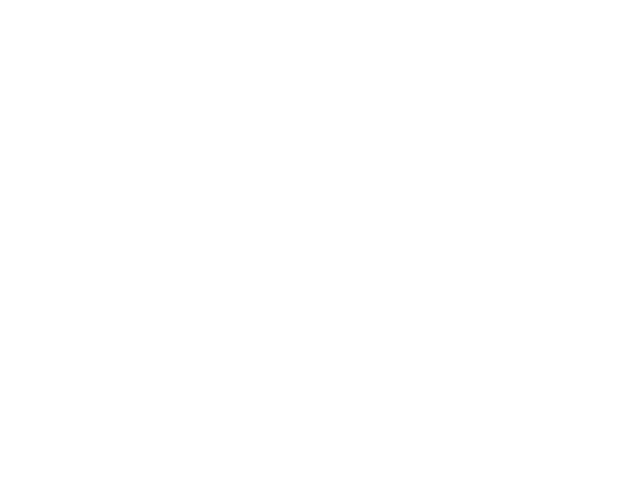

In [3]:
Igray = cv2.imread('cormoran_rgb.jpg', 0)

%matplotlib notebook
plt.figure(2)
plt.imshow(Igray, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

plt.figure('Histogram')
plt.hist(Igray.ravel(),256,[0,256]); 
plt.xlabel('Intensity')
plt.ylabel('Number of pixels')
plt.show()

II. Características RGB y algoritmo k-medias 
 Inicialmente abordaremos el problema de segmentación considerando como características los niveles de intensidad de las componentes R, G y B de la imagen original I. Para ello: 
 - Extraiga cada componente de color de la imagen I. 

In [4]:
I_R,I_G,I_B = cv2.split(I)


- Convierta cada componente en un vector columna utilizando el comando reshape. Así, por ejemplo, para almacenar como vector columna los niveles de intensidad de los píxeles de la componente R de I, utilizaremos la siguiente secuencia de instrucciones
I_R = I(:,:,1);
[nrows, ncols] = size(I_R); 
I_R_res = reshape(I_R,nrows*ncols,1); 

In [5]:
nrows, ncols = I_B.shape

I_B_res = np.reshape(I_B, (nrows*ncols,1))
I_R_res = np.reshape(I_R, (nrows*ncols,1))
I_G_res = np.reshape(I_G, (nrows*ncols,1))
print(I_G_res.shape)


(40000, 1)


- Represente el scatter plot de los datos utilizando la función plot3(haga uso del comando help para conocer su sintaxis). ¿Observa grupos de puntos claramente diferenciados?

<IPython.core.display.Javascript object>


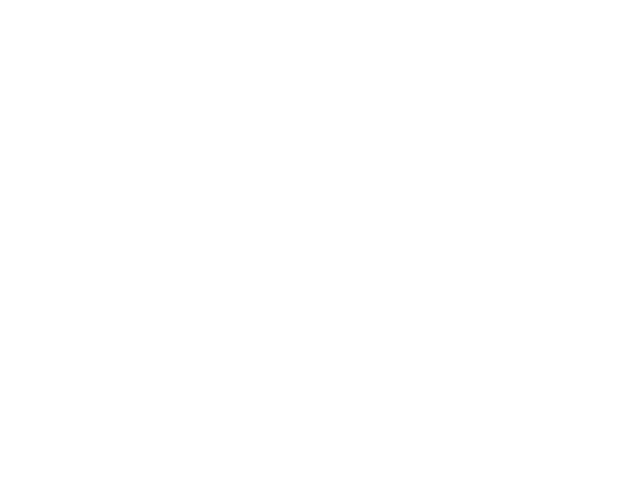

In [6]:
fig = plt.figure('scatter plot')
ax = fig.add_subplot(111, projection='3d')

ax.scatter(I_R_res, I_G_res, I_B_res, c='r', marker='.')

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

plt.show()

Sobre el espacio de tres dimensiones representado en la figura anterior aplicaremos el
algoritmo de agrupamiento k-medias con k=3. Utilizaremos para ello la función kmeans del
siguiente modo
ngrupos = 3;
rgb_res = double([I_R_res I_G_res I_B_res]);
[cluster_idx cluster_center] =
kmeans(rgb_res,ngrupos,'distance','sqEuclidean','Replicates',10);

Las entradas a la función kmeans son:

(1) conjunto de ejemplos/observaciones (matriz rgb_res, donde cada ejemplo es una fila y cada columna representa una característica),

(2)medida de similitud (cuadrado de la distancia Euclídea en nuestro caso, indicado a través del parámetro 'distance'),

y (3) número de inicializaciones (utilice el valor 10 en esta práctica, indicado con el parámetro 'Replicates').

El algoritmo kmeans devuelve la posición de los centroides (variable cluster_center) y una etiqueta identificativa del cluster al que pertenece cada punto de entrada (variable cluster_idx). Puesto que el algoritmo se realiza 10 veces con distintas  inicializaciones, la salida proporcionada corresponde a la realización para la que se obtiene la mínima suma de distancias intracluster.

Para observar el resultado del algoritmo k-medias, puede representar sobre el scatter plot
anterior los centroides resultantes del siguiente modo:
 plot3(cluster_center(:,1), cluster_center(:,2), cluster_center(:,3),'sr');
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
https://cmdlinetips.com/2018/04/how-to-concatenate-arrays-in-numpy/

(40000, 3)
[[177.88023493 162.98033708 113.75229826]
 [ 60.17733122  46.75286445  32.76590869]
 [196.33704909 219.53322811 230.63865049]]


<IPython.core.display.Javascript object>


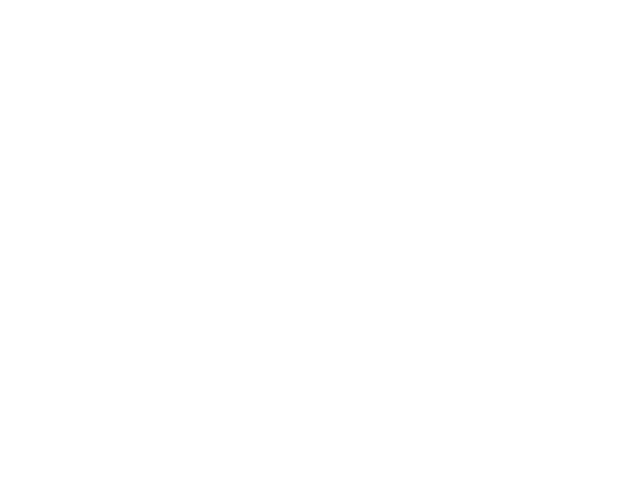

In [7]:
I_res = np.concatenate((I_R_res,I_G_res, I_B_res),axis=1)
print(I_res.shape)


kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(I_res)
print(kmeans.cluster_centers_)

fig = plt.figure('scatter plot +kmeans')
ax2 = fig.add_subplot(111, projection='3d')

ax2.scatter(I_R_res, I_G_res, I_B_res, c='r', marker='.')

ax2.set_xlabel('R')
ax2.set_ylabel('G')
ax2.set_zlabel('B')

ax2.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], s=1000, c='blue')
plt.show()

El resultado de la segmentación se puede observar en el espacio imagen generando una
imagen en falso color a partir del identificador de cluster asociado a cada observación
(píxel). Para ello, debe transformar el vector con la identificación del cluster al que
pertenece cada píxel en una matriz de las mismas dimensiones que la imagen original. Puede
hacer uso del siguiente código.

pixel_labels_rgb = reshape(cluster_idx,nrows,ncols);

I_segm = label2rgb(pixel_labels_rgb);

figure, imshow(I_segm)

¿Considera que el resultado de la segmentación es el deseado?, ¿es posible afirmar que se
produce sobresegmentación? Justifique razonadamente sus respuestas.

(40000,)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


<IPython.core.display.Javascript object>


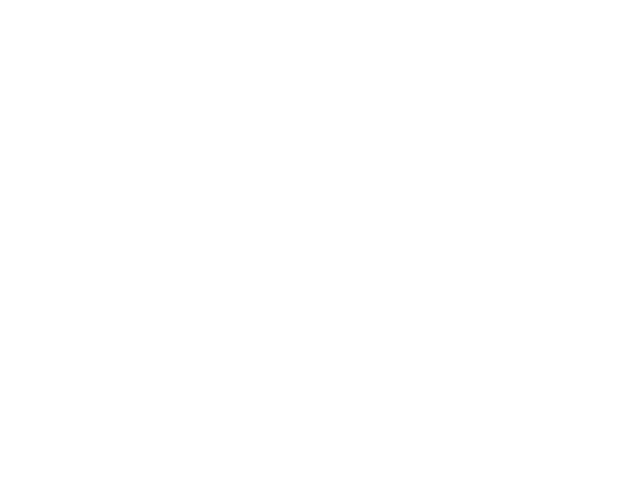

In [8]:
eti =kmeans.labels_
print(eti.shape)

pixel_labels = np.reshape(eti, (nrows, ncols))
print(pixel_labels)

%matplotlib notebook
plt.figure('I labeled')
plt.imshow(pixel_labels)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

III. Características cromáticas ab
Como sabe, en el espacio RGB la información cromática está distribuida en las tres
componentes (R, G y B). En esta sección realizaremos una transformación del espacio de
representación para separar las componentes cromáticas y acromáticas de la imagen, de
modo que aplicaremos el algoritmo k-medias únicamente sobre el espacio de componentes
cromáticas. La transformación considerada es la transformación Lab, transformación que
implementa la función rgb2lab proporcionada como material adjunto a la práctica.
Realice la transformación de la imagen original (espacio RGB) al espacio Lab y extraiga
únicamente las componentes cromáticas (componentes ab). Represente el scatter plot
correspondiente e intente identificar visualmente a qué color corresponden las nubes de
puntos.
[lab_imL, l_L, a_L, b_L] = rgb2lab(I);
a_res = reshape(a_L,nrows*ncols,1);
b_res = reshape(b_L,nrows*ncols,1);
figure, plot(a_res, b_res,'.')
xlabel('a'), ylabel('b')

<IPython.core.display.Javascript object>


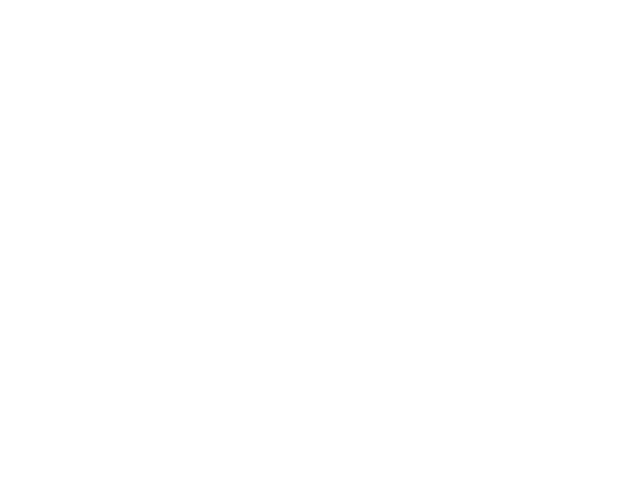

In [9]:
Lab_Im= cv2.cvtColor(I, cv2.COLOR_RGB2LAB)

L_l,L_a,L_b = cv2.split(Lab_Im)

L_a_res = np.reshape(L_a, (nrows*ncols,1))
L_b_res = np.reshape(L_b, (nrows*ncols,1))

plt.figure('ab scatter')
plt.scatter(L_a_res, L_b_res, c='blue', s= 1, marker='.')
plt.xlabel('a')
plt.ylabel('b')
plt.show()

Aplique ahora el algoritmo k-medias sobre el nuevo espacio de características y represente la
capa de etiquetas de la imagen segmentada. Comente las diferencias con la segmentación
obtenida en el Apartado II.
Represente la posición de los centroides en el scatter plot correspondiente y responda a las
siguientes preguntas:
- ¿cuál es la desviación típica (comando std de MATLAB) asociada a la componente a
obtenida a partir de I?
- ¿cuál es la desviación típica asociada a la componente b obtenida a partir de I?
- ¿cree que alguna de las dos componentes tiene más influencia al determinar la posición
de los centroides con el algoritmo k-medias?, ¿por qué?

[[132.35448365 143.25752671]
 [122.90225911 166.90871369]
 [122.87031245 119.82014343]]


<IPython.core.display.Javascript object>


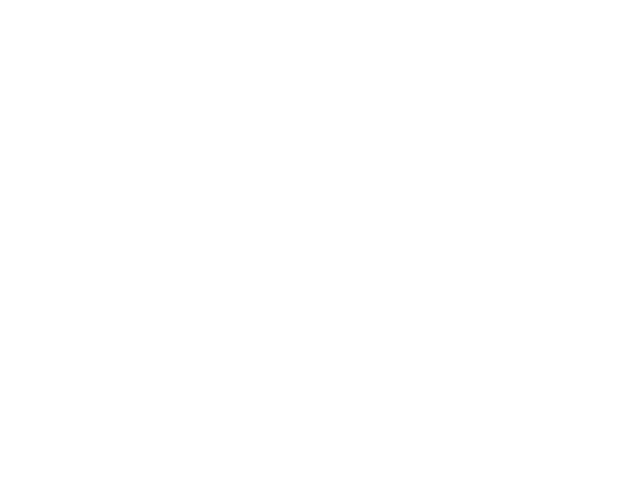

In [10]:
ab_res =np.concatenate((L_a_res, L_b_res), axis=1)


kmeans2 = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans2.fit_predict(ab_res)
print(kmeans2.cluster_centers_)


plt.figure('ab scatter +kmeans')
plt.scatter(L_a_res, L_b_res, c='blue', s= 1, marker='.')
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=300, c='red')
plt.show()

(40000,)
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]


<IPython.core.display.Javascript object>


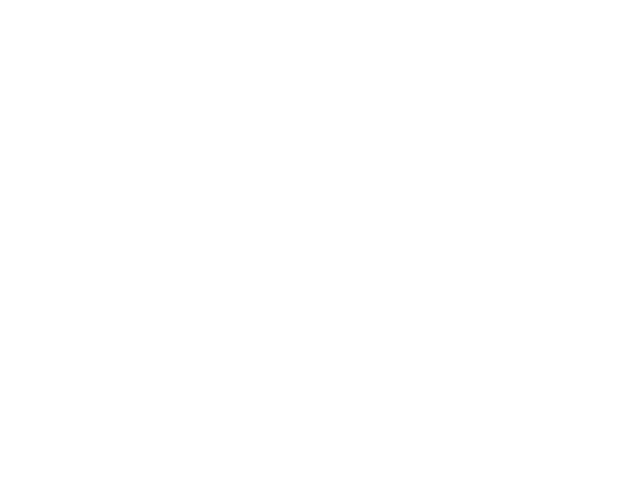

In [11]:
eti_ab =kmeans2.labels_
print(eti_ab.shape)

pixel_labels_ab = np.reshape(eti_ab, (nrows, ncols))
print(pixel_labels_ab)

%matplotlib notebook
plt.figure('ab labeled')
plt.imshow(pixel_labels_ab)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

Para que no haya una componente que domine en el cálculo de distancias del algoritmo kmedias únicamente porque su rango dinámico es mayor, se propone normalizar cada
componente del espacio ab para que tenga media nula y desviación típica uno. La matriz de
ejemplos con características normalizadas se asignará a la variable ab_norm (cada fila es un
ejemplo y cada columna es una característica). Explique cómo se realiza la normalización si
la secuencia de instrucciones es la siguiente:
ab_res = [a_res b_res];

ndim = size(ab_res,2);

ab_norm = ab_res;

for ind_dim=1:ndim

    datos = ab_res(:,ind_dim);
    datos_norm = (datos-mean(datos))/std(datos);
    ab_norm(:,ind_dim)=datos_norm;
end

<IPython.core.display.Javascript object>


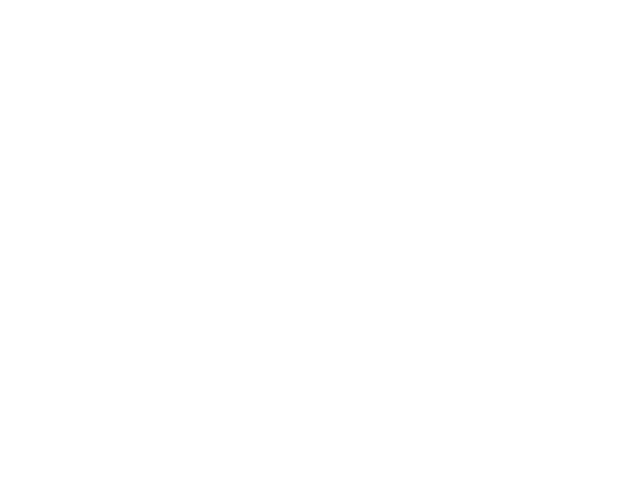

In [12]:
ab_res =np.concatenate((L_a_res, L_b_res), axis=1)

[x, ndim]= ab_res.shape
ab_norm = ab_res
ab_norm = ab_norm.astype(np.float64)
for ind in range (0, ndim):
    datos = ab_res[:,ind]
    datos_norm = (datos- np.mean(datos))/np.std(datos)
    ab_norm[:,ind] = datos_norm
    
L_a_norm = ab_norm[:, 0]
L_b_norm = ab_norm[:, 1]

plt.figure('ab scatter norm')
plt.scatter(L_a_norm, L_b_norm, c='blue', s= 1, marker='.')
plt.xlabel('a')
plt.ylabel('b')
plt.show()

Aplique ahora el algoritmo k-medias sobre el nuevo espacio de características y represente la capa de etiquetas de la imagen segmentada. Comente las diferencias con la segmentación obtenida en el Apartado II. 
 Represente la posición de los centroides en el scatter plot correspondiente y responda a las siguientes preguntas: - ¿cuál es la desviación típica (comando std de MATLAB) asociada a la componente a obtenida a partir de I?  - ¿cuál es la desviación típica asociada a la componente b obtenida a partir de I? - ¿cree que alguna de las dos componentes tiene más influencia al determinar la posición de los centroides con el algoritmo k-medias?, ¿por qué

[[-0.41071711 -0.46524178]
 [ 2.03318599  1.16297039]
 [-0.42569549  2.95707523]]


<IPython.core.display.Javascript object>


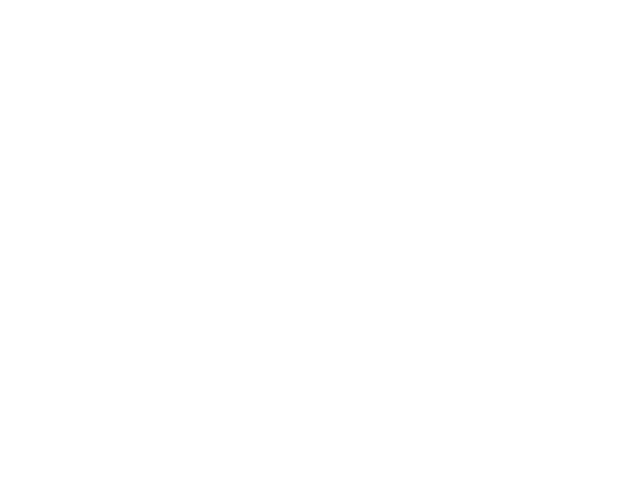

In [13]:
kmeansnorm = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_norm = kmeansnorm.fit_predict(ab_norm)
print(kmeansnorm.cluster_centers_)


plt.figure('ab_norm scatter +kmeans')
plt.scatter(L_a_norm, L_b_norm, c='blue', s= 1, marker='.')
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(kmeansnorm.cluster_centers_[:, 0], kmeansnorm.cluster_centers_[:, 1], s=300, c='red')
plt.show()

(40000,)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<IPython.core.display.Javascript object>


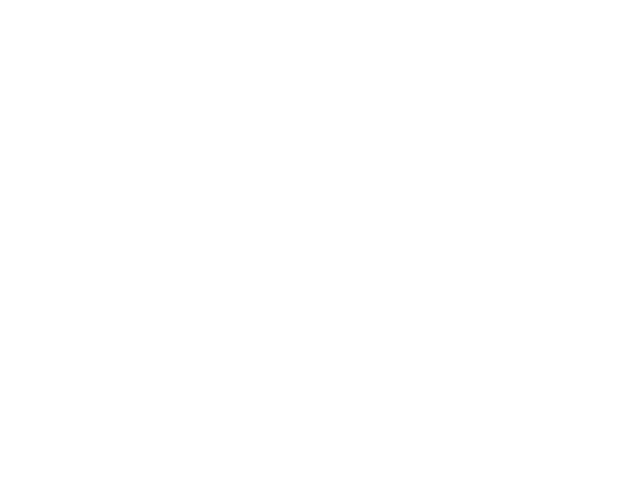

In [14]:
eti_ab_norm =kmeansnorm.labels_
print(eti_ab_norm.shape)

pixel_labels_ab_norm = np.reshape(eti_ab_norm, (nrows, ncols))
print(pixel_labels_ab_norm)

%matplotlib notebook
plt.figure('ab_norm labeled')
plt.imshow(pixel_labels_ab_norm)
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

IV. Características de textura

MATLAB proporciona una serie de filtros para extraer características relacionadas con la textura. La salida de cada filtro es una imagen del mismo tamaño que la imagen original donde cada píxel contiene la característica de textura extraída en un entorno local del mismo. Consulte la ayuda de las funciones stdfilt, entropyfilt y rangefilt de MATLAB e indique qué descriptor estadístico se obtiene con cada una de las tres funciones.

STDFILT

https://stackoverflow.com/questions/7331105/stdfilt-in-opencv/40027378#40027378

YES

<IPython.core.display.Javascript object>


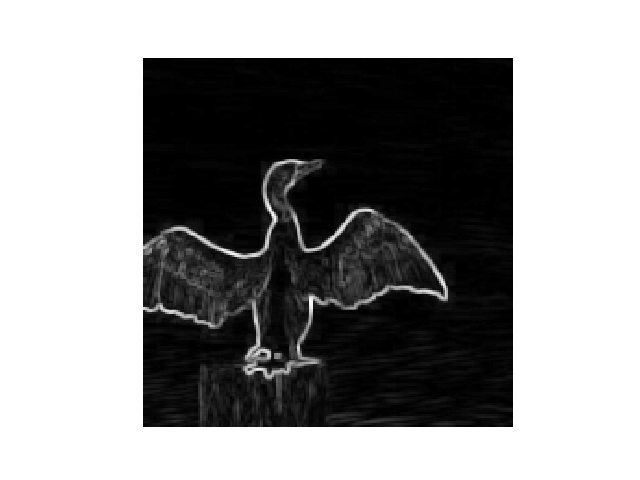

In [15]:
J = tf.stdfilt(Igray)

%matplotlib notebook
plt.figure('standar dev filter')
plt.imshow(J, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()

ENTROPYFILT

https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python
https://gist.github.com/jaradc/eeddf20932c0347928d0da5a09298147
https://stackoverflow.com/questions/20371053/finding-entropy-in-opencv


<IPython.core.display.Javascript object>


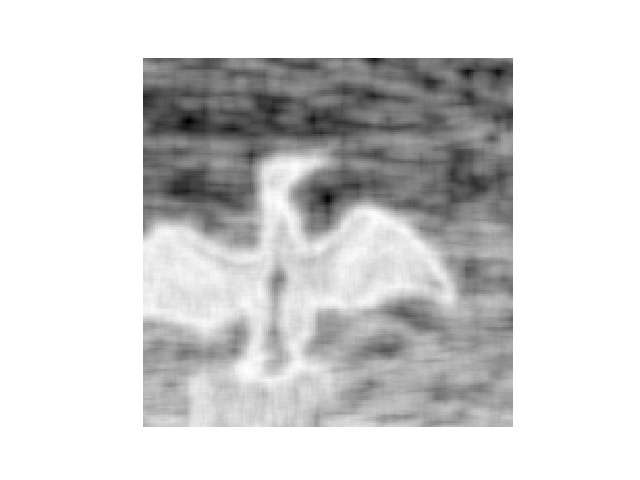

In [16]:
E = tf.entropyfilt(Igray)

plt.figure('entropy filter')
plt.imshow(E, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # this hides the axis ticks
for spine in plt.gca().spines.values():  #hide image border
    spine.set_visible(False)
plt.show()